# **Data Cleaning Notebook**

## Objectives

* Second attempt at data cleaning stage
* Data Exploration of missing data using ProfileReport
* Initial correlation analysis and PPS study
* Detailed evaluation of missing data
* Imputing strategies for missing data

## Inputs

* outputs/datasets/collection/house_prices_records_cleaned.csv

## Outputs

* Generate cleaned dataset

## Conclusions
* Drop variable - ['EnclosedPorch', 'WoodDeckSF', 'GarageYrBlt']
* Median Imputer - ['LotFrontage', '2ndFlrSF', 'MasVnrArea']
* Mean Imputer - 'BedroomAbvGr'
* Categorical Imputer - ['GarageFinish', 'BsmtFinType1']

## Additional Comments

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-issues'

# Load Data

Section 1 content

In [4]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/house_prices_records.csv"))
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


# Data Exploration

Create a list of the columns with missing data

In [5]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

* Generate pandas profile report of the variables with missing data.

In [6]:
from ydata_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]


Observations from pandas profile report:
* Almost 10% of total data is missing
* There are nine variables in total with missing data:
    * Seven numeric variables have data missing
    * Two categorical variables have data missing
* Variable 'WoodDeckSF' and 'EnclosedPorch' have 90.7% and 89.4% missing data respectively. Given the context, it is possible that the reason for the missing data is that the houses did not have a wood deck and/or porch, however, this is speculation and the data in that case should have been an entry of 0.

# Initial Correlation and PPS Analysis

* Correlation analysis is performed during the data cleaning process to identify inconsistencies or anomalies that require attention. 
* The initial analysis is performed only on numerical variables.

The following code taken from CI Churnometer project is designed to visualise the correlation and Predictive Power Score (PPS) matrices of the dataframe, in the following way:
* heatmap_corr: generates a heatmap to visualise the correlation matrix of the df. It masks values below a certain threshold and annotates the heatmap with correlation coefficients.
* heatmap_pps: generates a heatmap to visualise the PPS matrix of the df. It masks values below a certain threshold and annotates the heatmap with PPS scores.
* CalculateCorrAndPPS: calculates the Pearson and Spearman correlation matrices, as well as the PPS matrix of the input df.
* DisplayCorrAndPPS: displays the correlation matrices (Pearson and Spearman) and the PPS matrix using heatmaps.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Calculate Correlations and Power Predictive Score

In [8]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The 

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702


* From the PPS interquartile range we can see the majority of values are between 0 and 0.066, which indicates there is a concentration of features with moderate predictive power.
* A maximum PPS score of 0.702 suggests that there is at least one feature in the dataset that has a strong association with another feature.
* A threshold of 0.4 was chosen initially to display features with moderate correaltion or predictive power.

Generate heatmaps



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



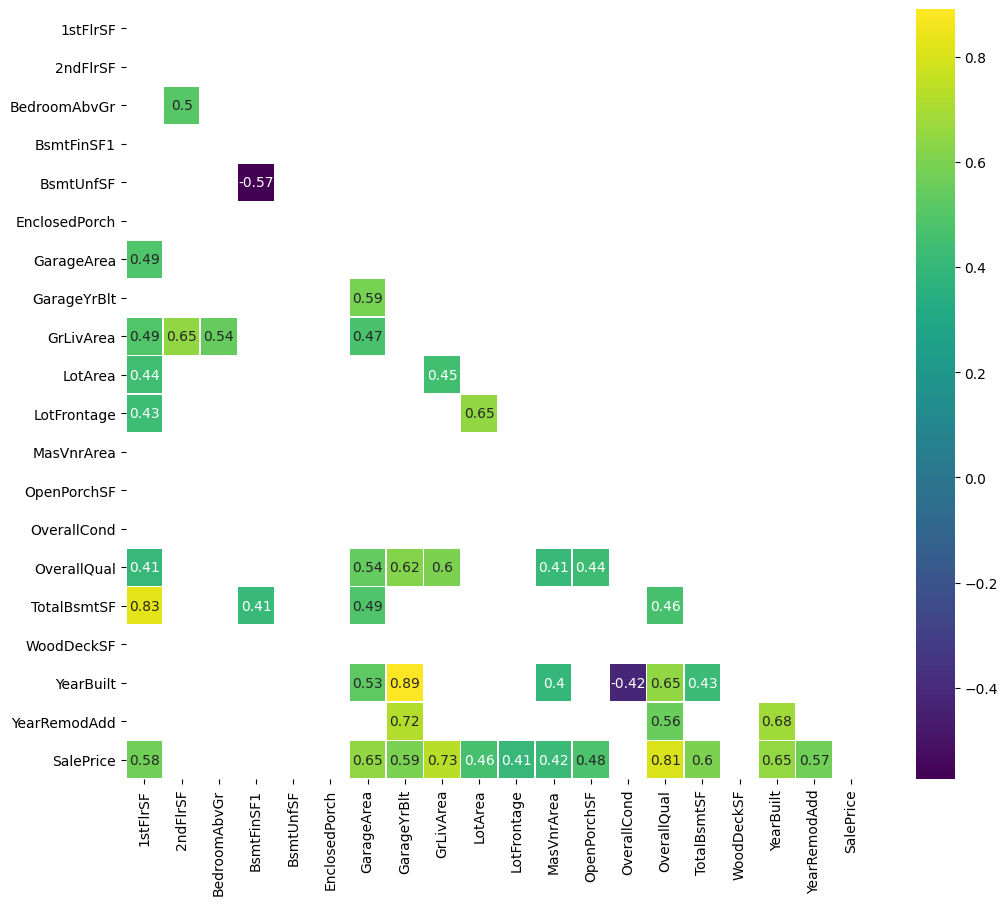



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



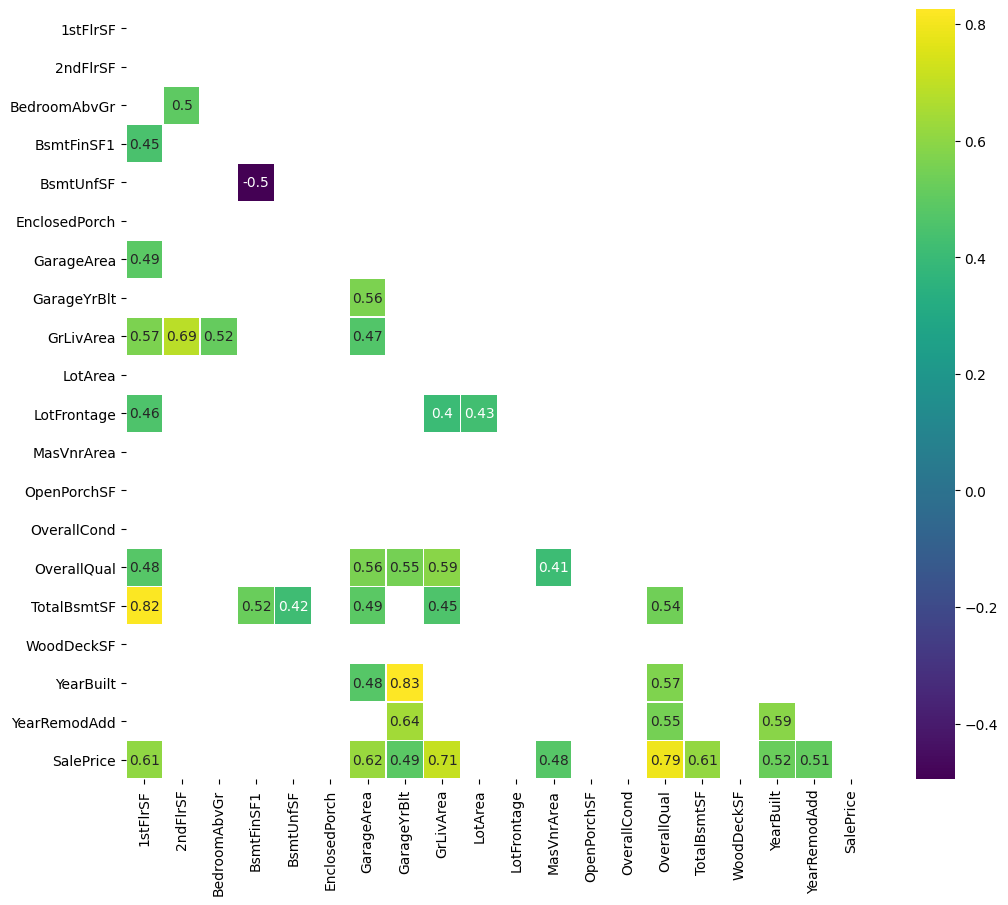



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



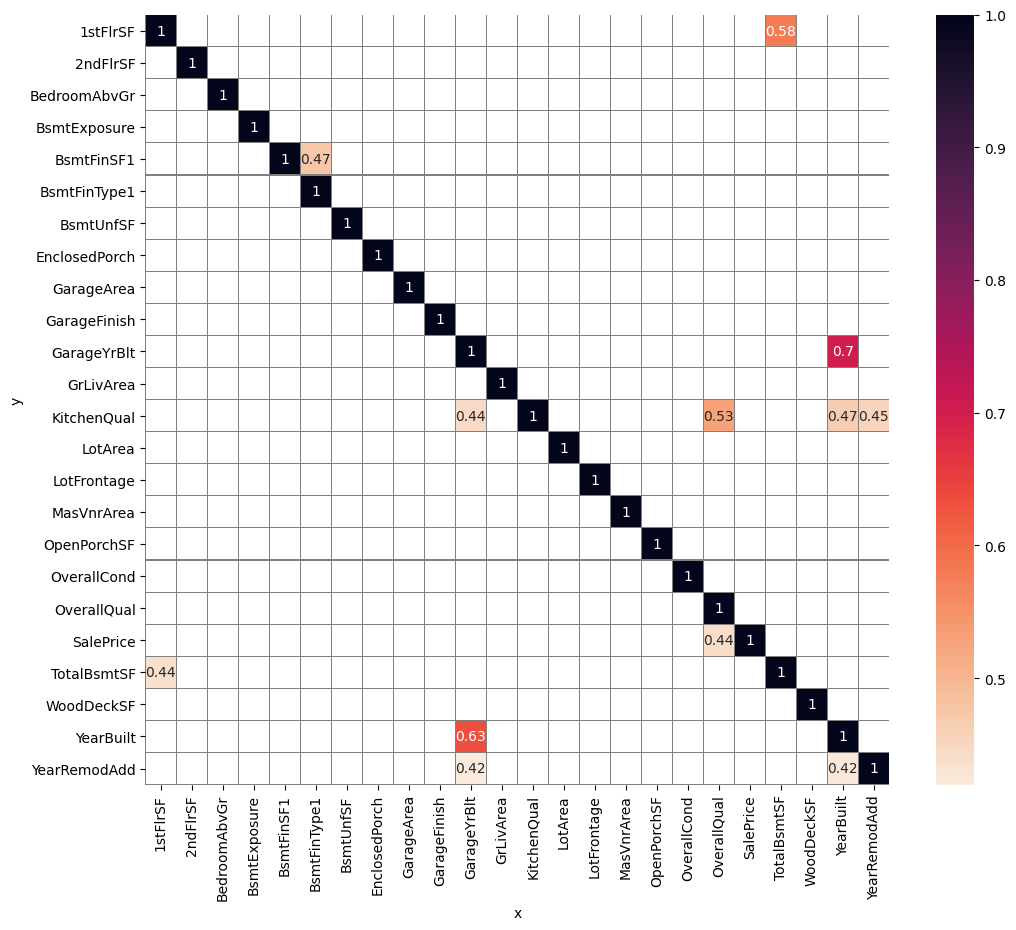

In [9]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.4,
                  figsize=(12,10), font_annot=10)

Observations from heatmap analyses:
* Sales price has moderate to strong monotonic relationship (Spearman correlation) with 12 house attributes.
* Sales price has moderate to strong linear relationship (Pearson correlation) with 9 house attributes.
* OverallQual and GrLivArea have the strongest predictive power for the target variable.
* Moderate to strong multicollinearity correlations exist between several features, as expected, such as YearBuilt and GarageYrBlt, and 1stFlrSF and TotalBsmtSF.


---

# Data Cleaning
## Assessing Missing Data Levels

* Custom function taken from CI Churnometer project to display missing data levels in a df, it shows the absolute levels, relative levels and data type.

In [10]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data


In [11]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


## Data Cleaning Spreadsheet Summary
After careful consideration of the missing data levels and analysis of variables in the context of the business case, the following approaches will be tried to deal with missing data.

### Enclosed Porch - 90.68% missing - drop variable

* The 'EnclosedPorch' variable will be dropped.
* We could assume that the reason for the missing data is that the properties in these observations had no enclosed porch. However, given that this would affect such a large portion of the data, it is reasonable to drop the variable.
* As such a large portion of the data is missing, this variable would not add much value to the model.

### Wood Deck Square Feet - 89.38% missing - drop variable

* The 'WoodDeckSF'variable will be dropped.
* We could assume that the reason for the missing data is that the properties in these observations had no wood deck. However, given that this would affect such a large portion of the data, it is reasonable to drop the variable.
* As such a large portion of the data is missing, this variable would not add much value to the model.

### Lot Frontage - 17.74% missing - median imputer
* The missing data in 'LotFrontage' will be imputed with the median value of 69.
* The median was chosen because the data is slightly skewed with a large spread. 
* Mean imputation with the value of 70 cis an alternative approach that could have been taken since the data is quite close to a normal distribution. Given the skew median imputation is likely to represent the missing data more accurately.
* It was considered that maybe the data is missing because the house does not have a front lot (front door of property opens directly onto street). However, closer inspection of the data shows that no observations recorded 0, and therefore it can be assumed that the data is missing for another reason, and that all Iowan houses have a front lot of some size.

### Garage Finish - 11.10% missing - categorical imputer with 'unf'
* The missing data in 'GarageFinish' will be categorically imputed with 'unf' to represent unfinished.
* It was considered that maybe the data is missing because the houses have no garages. However, on closer inspection of the 'GarageArea' variable we can see that the variable has no missing data and 5.5% recorded as 0 suggesting that 5.5% houses in the dataset have no garage. 'GarageFinish' has 5.6% recorded as 'None' meaning no garage and therefore the houses with no garage are accounted for in the 'GarageFinish' data.
* Since we know that the missing data is for houses that do have garages we will impute with the most common category which is 'unf' and is significantly more common than any other category in this dataset.

### Basement Finish Type 1 - 7.81% missing - categorical imputer with 'unf'
* The missing data in 'BsmtFinType1' will be categorically imputed with 'unf' to represent unfinished.
* It was considered that maybe the data is missing because the houses have no basement. However, on closer inspection of the 'TotalBsmtSF' variable we can see that the variable has no missing data and 2.5% recorded as 0 suggesting that 2.5% houses in the dataset have no basement. 'BsmtFinType1' has 2.3% recorded as 'None' meaning no basement and therefore the houses with no basement are mostly accounted for in the 'BsmtFinType1' data.
* Since we know that the missing data is for houses that do have basements we will impute with a category. Possible categories to impute with are 'unf' (unfinished) or 'glq' (good living quarters), which are the top most common categories and unfortunately have similar levels of 29.4% and 28.6% respectively, meaning we cannot confidently impute with either one of these categories.
* It was considered whether we could drop the rows with missing data, however, we would lose 7.81% of our data which is too much data to lose.
* It was considered whether we could drop the variable altogether. This could be a reasonable approach, since we know that 'BsmtFinType1' has only a weak correlation with the target variable.
* Taking all of these factors into consideration, it was decided better not to lose any data and to impute with the most common category of 'unf'.

### Bedrooms Above Grade - 6.78% missing - mean imputer
* The missing data in 'BedroomAbvGr' will be imputed with the mean value of 2.87.
* The mean was chosen as the distribution of this data is close to normal distribution (standard deviation is 0.8).
* Median imputation would also have been a reasonable approach to take (median is 3) with this data.

### 2nd Floor Square Feet - 5.89% missing - median imputer
* The missing data for the variable '2ndFlrSF' will be imputed with the value of 0.
* 0 is the median value for this data.
* 0 holds significance as it represents houses without a second storey.

### Garage Year Built - 5.55% missing - drop variable
* The 'GarageYrBlt' variable will be dropped.
* There is a problem with the collection of this data. Houses with no garage do not have a year that the garage was built. Even choosing 0 would not work, as that suggests year 0.
* On closer inspection of the 'GarageArea' variable, which has no missing data we can see that 5.5% have recorded 0, suggesting 5.5% of houses have no garage. This precentage matches with the missing data in 'GarageYrBlt'.
* We cannot impute a year for a garage that does not exist.
* It was considered to drop rows with missing data, but then we would drop all of the houses with no garage which would result in an inaccurate dataset.
* Although 'GarageYrBlt' has a strong correlation to the target variable, the dataset also has variables for the year the house was built and the year of remodelling, both of which were strongly correlated to the garage year built and therefore dropping 'GarageYrBlt' should not affect the model too much because other related house attributes capture the age of the property.

### Masonry Veneer Area - 0.55% missing - median imputer
* The missing data for the variable 'MasVnrArea' will be imputed with the value of 0.
* 0 is the median value for this data.
* 0 holds significance as it represents houses without masonry veneer.

## Dealing with Missing Data

DataCleaningEffect() is a custom function from CI's Feature Engine module

Function objective: assess the effect of cleaning the data, when:
* mean, median or arbitrary value imputation is performed on a numerical variable.
* 'Missing' or the most frequest category is used to impute categorical variables

Parameters: 
* df_original: data not cleaned
* df_cleaned: cleaned data
* variables_applied_with_method: variables where you applied a given method



In [12]:
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
    # first on variables that you applied the method
    # if the variable is a numerical plot, a histogram if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1

### Data Cleaning Summary
* Drop - ['EnclosedPorch', 'WoodDeckSF', 'GarageYrBlt']
* Median Imputer - ['LotFrontage', '2ndFlrSF', 'MasVnrArea']
* Mean Imputer - ['BedroomAbvGr', ]
* Categorical Imputer - ['GarageFinish', 'BsmtFinType1']

### Drop Variables

In [13]:
from feature_engine.selection import DropFeatures

variables_method = ['EnclosedPorch', 'WoodDeckSF', 'GarageYrBlt' ]
variables_method

imputer = DropFeatures(features_to_drop=variables_method)
df_method = imputer.fit_transform(df)
df_method.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GrLivArea,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,1710,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1262,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,1786,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,642,Unf,1717,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,836,RFn,2198,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


### Mean Median Imputation

* Assess the effect of median imputation


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['LotFrontage', '2ndFlrSF', 'MasVnrArea'] 




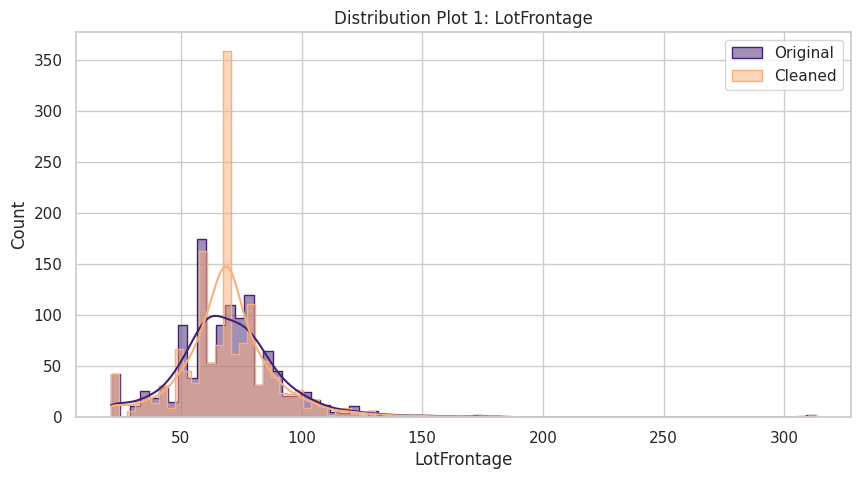

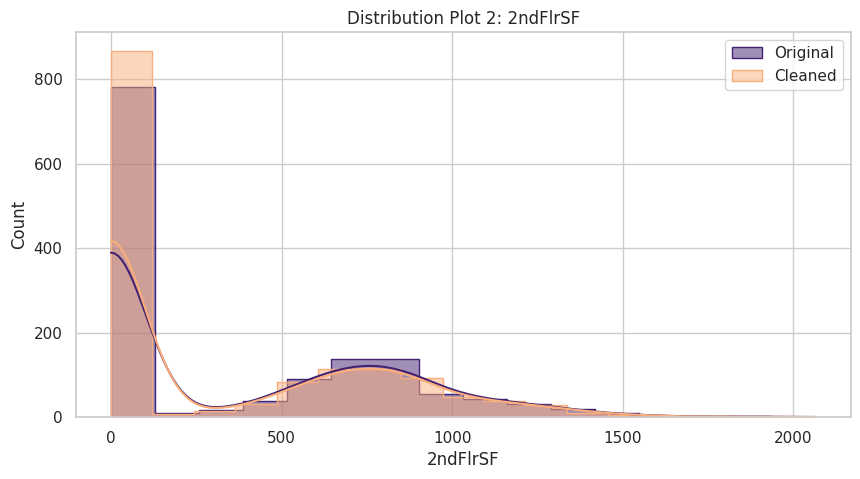

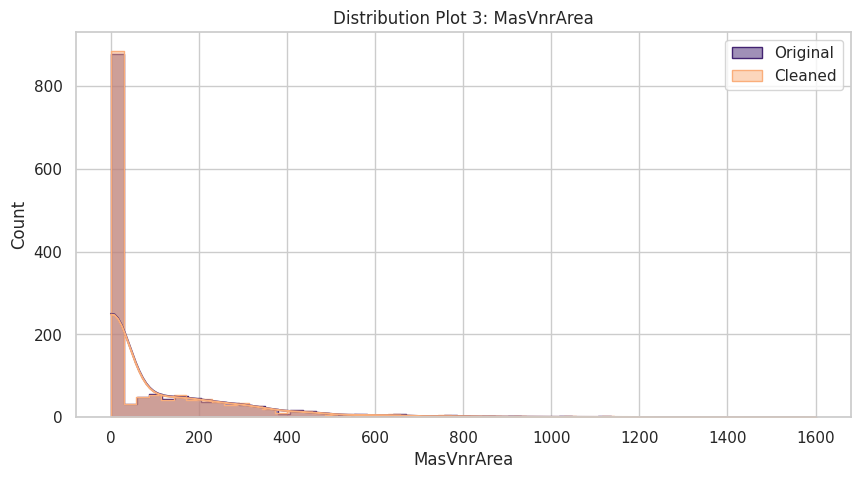

In [14]:
from feature_engine.imputation import MeanMedianImputer

variables_method = ['LotFrontage', '2ndFlrSF', 'MasVnrArea']
variables_method


imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
                            
df_method = imputer.fit_transform(df)

DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

* Assess the effect of mean imputation


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['BedroomAbvGr'] 




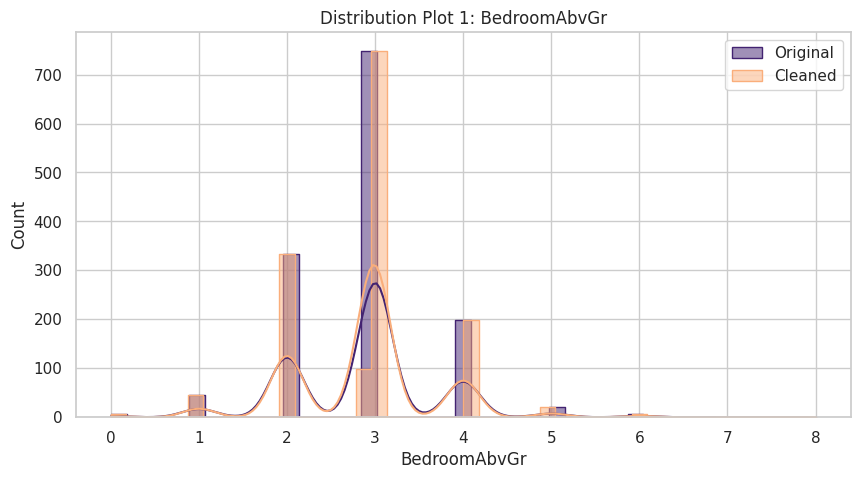

In [15]:
variables_method = ['BedroomAbvGr']
variables_method


imputer = MeanMedianImputer(imputation_method='mean', variables=variables_method)
                            
df_method = imputer.fit_transform(df)

DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

### Categorical Imputation


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['GarageFinish', 'BsmtFinType1'] 




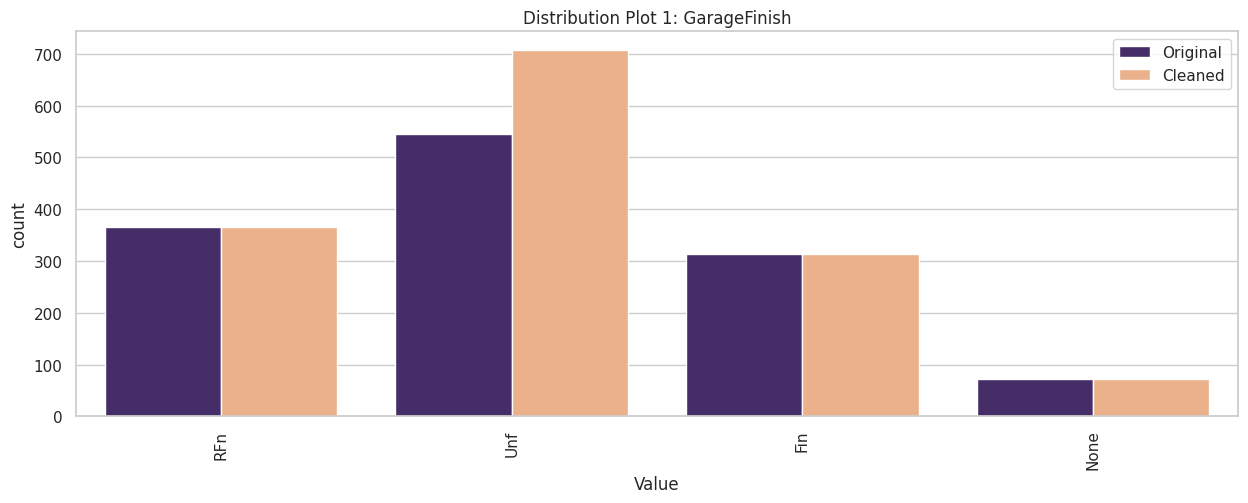

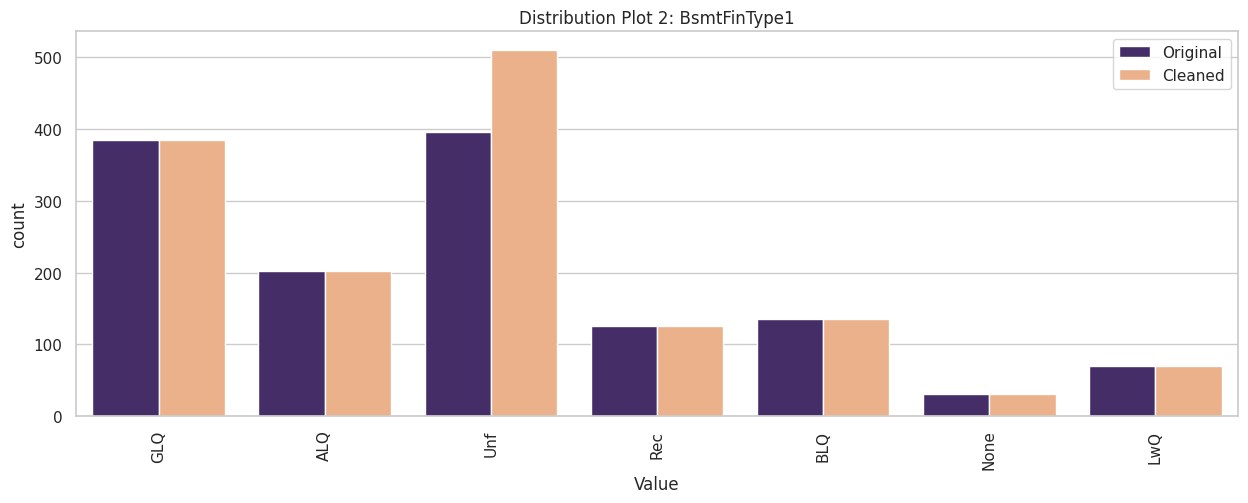

In [16]:
from feature_engine.imputation import CategoricalImputer

variables_method = ['GarageFinish', 'BsmtFinType1']
variables_method

imputer = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=variables_method)
df_method = imputer.fit_transform(df)

DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

* After comparison of the original and cleaned data, we accept the imputation methods, and apply them to the train and test sets.

Create data cleaning pipeline

In [19]:
from sklearn.pipeline import Pipeline

pipeline_base = Pipeline([

        # Data Cleaning
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF', 'GarageYrBlt'])),

        ("CategoricalImputation", CategoricalImputer(imputation_method='missing',fill_value='Unf', 
                                                        variables=['GarageFinish','BsmtFinType1'])),
        
        ("MedianImputation", MeanMedianImputer(imputation_method='median', 
                                                variables=['LotFrontage', '2ndFlrSF', 'MasVnrArea'])),

        ("MeanImputation", MeanMedianImputer(imputation_method='mean', variables='BedroomAbvGr')),
])

pipeline_base

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF',
                                                'GarageYrBlt'])),
                ('CategoricalImputation',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MedianImputation',
                 MeanMedianImputer(variables=['LotFrontage', '2ndFlrSF',
                                              'MasVnrArea'])),
                ('MeanImputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables='BedroomAbvGr'))])

Apply data cleaning pipeline to the data frame.

In [20]:
cleaned_df = pipeline_base.fit_transform(df)

* Evaluate missing data

In [22]:
df_missing_data = EvaluateMissingData(cleaned_df)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 0 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType


## Data Cleaning Conclusions
* Missing data has been eliminated from the dataset using the following methods.

    * Drop variable - ['EnclosedPorch', 'WoodDeckSF', 'GarageYrBlt']
    * Median Imputer - ['LotFrontage', '2ndFlrSF', 'MasVnrArea']
    * Mean Imputer - ['BedroomAbvGr', ]
    * Categorical Imputer - ['GarageFinish', 'BsmtFinType1']

* Data quality improvements:
    * For variables '2ndFlrSF', 'MasVnrArea', 'Lotfrontage' and 'BedroomAbvGr' the shape of the distribution remained the same after data cleaning, with only slight increase in peak height due to imputation.
* Data quality concerns:
    * The categorical imputations have changed the relative distribution of the categories by a small amount.
    * Dropping the 'GargeYrBlt' variable seems quite drastic given a relatively small amount of missing data, however, it was considered the best approach after careful consideration of all factors (as discussed above).



## Next Steps
* Detailed correlation study
* Generate data visualisations to answer client business requirement.


# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [23]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned') # create a folder for the data output
except Exception as e:
  print(e)

cleaned_df.to_csv(f"outputs/datasets/cleaned/house_prices_records_cleaned.csv",index=False)


[Errno 17] File exists: 'outputs/datasets/cleaned'
